# Wrangling Data From Bay Area Bike Share Published Data - Stations

### Import Packages

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import datetime

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("poster")

In [2]:
from wranglingutils import time_marker as tm
from wranglingutils import csv_chunk_importer
from wranglingutils import landmark_to_zip

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

font = {'size'   : 50}
matplotlib.rc('font', **font)

COLOR_BLU = '#0074C8'
COLOR_YEL = '#FACD6B'
COLOR_GRY = '#71C9BE'

LABEL_FONT_SIZE = 15
TITLE_FONT_SIZE = 25
TICK_FONT_SIZE = LABEL_FONT_SIZE*0.8
FIG_SIZE = (15,6)

## Key Dates from data source notes

In [4]:
FIRST_SERVICE_DATE = datetime.datetime.strptime('2013-08-29', '%Y-%m-%d')
LAST_SERVICE_DATE  = datetime.datetime.strptime('2016-08-31', '%Y-%m-%d')

## Import Data

In [5]:
stations_df = csv_chunk_importer(file_path_slug='../00_source_data/bayareabikeshare/*_station_data.csv', 
                                 column_labels=['station_id', 'name', 'lat', 'long', 'dock_count', 'landmark', 'first_service_date'], 
                                 chunk_size=100)

[20:49:56.684017] Started Loading Data...
[20:49:56.695445] Finished file! ( 0 of  4)
[20:49:56.741855] Finished file! ( 1 of  4)
[20:49:56.746986] Finished file! ( 2 of  4)
[20:49:56.751908] Finished file! ( 3 of  4)
[20:49:56.752081] concatenating chunks...
[20:49:56.758500] Data Loaded Successfully!


In [6]:
stations_df.head()

,station_id,name,lat,long,dock_count,landmark,first_service_date
0,2.0,San Jose Diridon Caltrain Station,37.329732,-121.901782,27.0,San Jose,8/6/2013
1,3.0,San Jose Civic Center,37.330698,-121.888979,15.0,San Jose,8/5/2013
2,4.0,Santa Clara at Almaden,37.333988,-121.894902,11.0,San Jose,8/6/2013
3,5.0,Adobe on Almaden,37.331415,-121.893200,19.0,San Jose,8/5/2013
4,6.0,San Pedro Square,37.336721,-121.894074,15.0,San Jose,8/7/2013


In [7]:
stations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1201 entries, 0 to 1200
Data columns (total 7 columns):
station_id            276 non-null float64
name                  276 non-null object
lat                   276 non-null float64
long                  276 non-null float64
dock_count            276 non-null float64
landmark              276 non-null object
first_service_date    276 non-null object
dtypes: float64(4), object(3)
memory usage: 65.8+ KB


## Cleaning Support Functions
<p>General Cleaning functions</p>

In [8]:
def clean_data_types(df):
    ''' given a station dataframe, clean up the datatype for each column '''
    
    # these data columns are included in the imported data set
    df['station_id']         = df['station_id'].astype('int')
    df['name']               = df['name'].astype('str')
    df['lat']                = df['lat'].astype('float')
    df['long']               = df['long'].astype('float')
    df['landmark']           = df['landmark'].astype('category')
    df['dock_count']         = df['dock_count'].astype('int')
    df['first_service_date'] = pd.to_datetime(df['first_service_date'], format='%m/%d/%Y', errors='coerce')
    
    
    # these data columns are added through the cleaning process, only clean them if they exist
    try:
        df['last_service_date']  = pd.to_datetime(df['last_service_date'], format='%m/%d/%Y', errors='coerce')
        df['zip_code']           = df['zip_code'].astype('str')
        df['days_in_service']    = df['days_in_service'].astype('int')
    except:
        pass
    
    return df


def correct_first_service_date(row):
    ''' adjust first service dates which are prior to the program start date'''
    if row.first_service_date < FIRST_SERVICE_DATE:
        result = FIRST_SERVICE_DATE
    else:
        result = row.first_service_date
    return result


def days_in_service(row):
    ''' returns an integer of the number of days the statin was in service'''
    days_in_service = row.last_service_date - row.first_service_date
    
    try:
        result = int(days_in_service.days)
    except:
        result = 999999
    
    return result

## Clean Data

In [9]:
tm('Station Data Cleanup Started...')
# drop na values and drop duplicates
stations_df.dropna(how='all', inplace=True)
stations_df.drop_duplicates(inplace=True)

# cleanup data types
stations_df = clean_data_types(stations_df)

# sort by 'station_id' and rest index
stations_df.sort_values('station_id', inplace=True)
stations_df.reset_index(drop=True, inplace=True)
tm('Station Data Cleanup Complete!')

[20:49:56.927412] Station Data Cleanup Started...
[20:49:56.942581] Station Data Cleanup Complete!


## Add `zip_code` and `last_service_date` columns
<p> Appending columns of data from other data sets, or from computations on given data.</p>

In [10]:
# add 'last_service_date' column to coenside with last data from data
stations_df['last_service_date'] = LAST_SERVICE_DATE

# add 'zipcode' column to station, this is handy for cross comparison to other datasets
stations_df['zip_code'] = stations_df.apply(lambda row: landmark_to_zip (row), axis=1)

## Special Cleaning Notes
<p>This data set is not so large that some cleaning is more easily done manually from notes included from Bay Area Bike Share.</p>

In [11]:
def clean_from_notes(df):
    ''' Manual Fixes from included notes in published dataset'''
    
    index_drop_list = []
    
    # FROM NOTES - correct installation dates prior to 8/29/13, to 8/29/13
        # Cleaning Step : adjust all dates prior to service start dates to FIRST_SERVICE_DATE
    df['first_service_date'] = df.apply(lambda row: correct_first_service_date (row), axis=1)

    # FROM NOTES - Station 23: From 9/1/14 – 10/22/14: This station was located at (37.488501, -122.231061). 
        # Cleaning Step : this move is across the block, throw out new location record
    index_drop_list.append(17)
    df.loc[17, 'station_id'] = 'JUNK'

    # FROM NOTES - Station 25: From 9/1/14 – 10/22/14: This station was located at (37.486725, -122.225551). It was previously named “Broadway at Main.”
        # Cleaning Step : station is renamed and moved over a mile, update last and first service dates for row
    df.loc[19,'last_service_date']  = datetime.datetime.strptime('2014-08-31', '%Y-%m-%d')
    df.loc[20,'first_service_date'] = datetime.datetime.strptime('2014-09-01', '%Y-%m-%d')

    # FROM NOTES - Station 49: From 9/1/14 - 2/5/15: This station was located at (37.789625, -122.390264). 
        # Cleaning Step : station was moved around the block, throw out new location record
    index_drop_list.append(44)
    df.loc[44, 'station_id'] = 'JUNK'
    
    # FROM NOTES - Station 69: From 9/1/14 – 3/11/15: This station was located at (37.776377,-122.39607). 
        # Cleaning Step : station was moved around the block, throw out new location record
    index_drop_list.append(63)
    df.loc[63, 'station_id'] = 'JUNK'

    # FROM NOTES - Station 72: Moved twice. From 9/1/14 – 2/12/15, this station was located at (37.780356, -122.412919). 
    #                                       From 2/13/15 to 6/3/15, the station was located at (37.780353, -122.41226). 
        # Cleaning Step : the station was only relocated once on 2/13/15, not twice.  move was around the corner, toss out latest record
    index_drop_list.append(67)
    df.loc[67, 'station_id'] = 'JUNK'
        
    # FROM NOTES - Station 80: On 9/1/14, this station changed names from "San Jose Government Center" to "Santa Clara County Civic Center." It did not move.
        # Cleaning Step : name change, second name is better, throw out original name
    index_drop_list.append(74)
    df.loc[74, 'station_id'] = 'JUNK'
        
    # FROM NOTES - Station 21: On 9/16/15, this station was renamed from "Franklin at Maple" to "Sequoia Hospital" and moved to (37.479303,-122.253755)
        # Cleaning Step : this is a significant move, create a new row, and adjust start and end dates
    df.loc[14,'last_service_date']  = datetime.datetime.strptime('2015-09-14', '%Y-%m-%d')
    station_21_copy = df.loc[14,:].copy()
    station_21_copy.lat = 37.479303
    station_21_copy.long = -122.253755
    station_21_copy.first_service_date = datetime.datetime.strptime('2015-09-15', '%Y-%m-%d')
    station_21_copy.last_service_date = LAST_SERVICE_DATE
    df.loc[100] = station_21_copy
    df.loc[100, 'name'] = 'Sequoia Hospital'


    # FROM NOTES - Station 26: On 9/16/15, this station was renamed from "Redwood City Medical Center" to "Kaiser Hospital" and moved to (37.489704,-122.224728)
        # Cleaning Step :  station was moved around the block, nothing to do here
    
    # FROM NOTES - Station 30: On 9/28/15, this station was renamed from "Evelyn Park and Ride" to "Middlefield Light Rail Station" and moved to (37.395337,-122.052476)
        # Cleaning Step : this is a substantial move, update start and end dates
    df.loc[25,'last_service_date']  = datetime.datetime.strptime('2015-09-27', '%Y-%m-%d')
    df.loc[26,'first_service_date'] = datetime.datetime.strptime('2015-09-28', '%Y-%m-%d')

    # FROM NOTES - Station 33: On 9/16/15, this station was renamed from "Rengstorff Avenue / California Street" to "Charleston Park/ North Bayshore Area" and moved to (37.420909,-122.080623)
        # Cleaning Step : this is a substantial move, update start and end dates
    df.loc[29,'last_service_date']  = datetime.datetime.strptime('2015-09-14', '%Y-%m-%d')
    df.loc[30,'first_service_date'] = datetime.datetime.strptime('2015-09-15', '%Y-%m-%d') 

    # FROM NOTES - Station 73: Moved twice. From 3/14/16 – 5/19/16, this station was located at (37.797746, -122.407073). From 5/19/16 to 8/31/16, the station was located at (37.7979, -122.405942). The station name stayed the same for all moves. 
        # Cleaning Step : the move is around the block, but more stations were added
    df.loc[68,'last_service_date']  = datetime.datetime.strptime('2015-05-19', '%Y-%m-%d')
    df.loc[69,'first_service_date'] = datetime.datetime.strptime('2015-05-20', '%Y-%m-%d')

    # FROM NOTES - Station 83: On 9/16/15, this station was renamed from "Mezes Park" to "Mezes" and moved to (37.491405,-122.233051)
        # Cleaning Step : moved around corner, nothing to clean

    # FROM NOTES - Note 2: On 6/30/16, Service in Redwood City was discontinued due to low usage. This included 7 stations: 21, 22, 23, 24, 25, and 26.
        # Cleaning Step : set last_service_date on these stations
    df.loc[15,'last_service_date']  = datetime.datetime.strptime('2016-06-30', '%Y-%m-%d')
    df.loc[16,'last_service_date']  = datetime.datetime.strptime('2016-06-30', '%Y-%m-%d')
    df.loc[17,'last_service_date']  = datetime.datetime.strptime('2016-06-30', '%Y-%m-%d')
    df.loc[18,'last_service_date']  = datetime.datetime.strptime('2016-06-30', '%Y-%m-%d')
    df.loc[20,'last_service_date']  = datetime.datetime.strptime('2016-06-30', '%Y-%m-%d')
    df.loc[21,'last_service_date']  = datetime.datetime.strptime('2016-06-30', '%Y-%m-%d')
    df.loc[77,'last_service_date']  = datetime.datetime.strptime('2016-06-30', '%Y-%m-%d')
    df.loc[100,'last_service_date']  = datetime.datetime.strptime('2016-06-30', '%Y-%m-%d')  # station 21 update, special index
    

    # FROM NOTES - Four of these stations have since been moved to either San Francisco or San Jose. (Stations 23, 24, 25 and 26 have become stations 88, 89, 90 and 91 respectively). Although these stations were promptly re-named, there was a delay in assigning them new station IDs. Full details:
        # Cleaning Step 

    # FROM NOTES - On 7/5/16, Station 23, "San Mateo County Center," was renamed to be "5th S. at E. San Salvador St.” On 8/24/16, the station was reassigned to Station 88.
        # Cleaning Step :  79
    df.loc[16, 'last_service_date']  = datetime.datetime.strptime('2016-07-04', '%Y-%m-%d')
    df.loc[79,'first_service_date']  = datetime.datetime.strptime('2016-07-05', '%Y-%m-%d')


    # FROM NOTES - On 7/5/16, Station 24, "Redwood City Public Library," was renamed to be "S. Market St at Park Ave.” On 8/24/16, the station was reassigned to Station 89.
        # Cleaning Step :  80
    df.loc[18, 'last_service_date']  = datetime.datetime.strptime('2016-07-04', '%Y-%m-%d')
    df.loc[80,'first_service_date']  = datetime.datetime.strptime('2016-07-05', '%Y-%m-%d')


    # FROM NOTES - On 8/4/16, Station 25, "Stanford in Redwood City," was renamed to be "Cyril Magnin St at Ellis St.” On 8/24/16, the station was reassigned to Station 91.
        # Cleaning Step :  82
    df.loc[20, 'last_service_date']  = datetime.datetime.strptime('2016-08-03', '%Y-%m-%d')
    df.loc[82,'first_service_date']  = datetime.datetime.strptime('2016-08-04', '%Y-%m-%d')


    # FROM NOTES - On 8/4/16, Station 26, "Kaiser Hospital," was renamed to be "5th St at Folsom St.” On 8/24/16, the station was reassigned to Station 90.
        # Cleaning Step :  81
    df.loc[21, 'last_service_date']  = datetime.datetime.strptime('2016-08-03', '%Y-%m-%d')
    df.loc[81,'first_service_date']  = datetime.datetime.strptime('2016-08-04', '%Y-%m-%d')
    

    # drop all rows in drop list and clean/reset index
    df.drop(index_drop_list, inplace=True)
    df.sort_values(['station_id', 'first_service_date'], inplace=True)
    df.reset_index(inplace=True, drop=True)
    
    
    return df

In [12]:
stations_df = clean_from_notes(stations_df)

In [13]:
stations_df[stations_df.station_id == 25]

,station_id,name,lat,long,dock_count,landmark,first_service_date,last_service_date,zip_code
19,25,Stanford in Redwood City,37.485370,-122.203288,15,Redwood City,2013-08-29,2014-08-31,94063
20,25,Broadway at Main,37.486725,-122.225551,15,Redwood City,2014-09-01,2016-08-03,94063


In [14]:
stations_df.tail()

,station_id,name,lat,long,dock_count,landmark,first_service_date,last_service_date,zip_code
74,84,Ryland Park,37.342725,-121.895617,15,San Jose,2014-04-09,2016-08-31,95113
75,88,5th S. at E. San Salvador St,37.331957,-121.881630,19,San Jose,2016-07-05,2016-08-31,95113
76,89,S. Market st at Park Ave,37.332398,-121.890429,19,San Jose,2016-07-05,2016-08-31,95113
77,90,5th St at Folsom St,37.780148,-122.403158,31,San Francisco,2016-08-04,2016-08-31,94107
78,91,Cyril Magnin St at Ellis St,37.785908,-122.408891,35,San Francisco,2016-08-04,2016-08-31,94107


## Add `days_in_service` Column
<p>Days in service is the number of days between the `last_service_data` and `first_service_date`</p>

In [15]:
# days in service is useful for popularity comparison as some stations were opened and closed on different dates
stations_df['days_in_service'] = stations_df.apply(lambda row: days_in_service (row),axis=1)

# final data type cleaning pass
stations_df = clean_data_types(stations_df)

# Append Station Elevation
<p>The Bay Area is notoriously hilly, elevation might be a good thing to consider when looking at ridreship trends.  Poll the Google Maps Elevation API to get the elevation of each station.</p>

In [16]:
import json
from time import sleep
import urllib.request

import os
GOOGLE_MAPS_KEY = os.environ.get('GOOGLE_MAPS_ELEVATION_KEY')

In [17]:
def get_elevation(lat, lon):
    elevation = 0
    req_url = 'https://maps.googleapis.com/maps/api/elevation/json?locations=%s,%s&key=%s' % (lat, lon, GOOGLE_MAPS_KEY)

    with urllib.request.urlopen(req_url) as url:
        url_json_response = json.loads(url.read().decode())

    result = url_json_response['results']
    elevation = result[0]['elevation']
        
    return elevation

In [18]:
stations_df['elevation_meters'] = stations_df.apply(lambda row: get_elevation(row['lat'], row['long']), axis=1)
stations_df['elevation_feet'] = stations_df['elevation_meters'] / 0.3048

stations_df.head(5)

,station_id,name,lat,long,dock_count,landmark,first_service_date,last_service_date,zip_code,days_in_service,elevation_meters,elevation_feet
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-29,2016-08-31,95113,1098,28.275824,92.768450
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,2013-08-29,2016-08-31,95113,1098,28.038095,91.988502
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,2013-08-29,2016-08-31,95113,1098,25.517740,83.719620
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,2013-08-29,2016-08-31,95113,1098,26.192633,85.933834
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,2013-08-29,2016-08-31,95113,1098,25.543407,83.803830


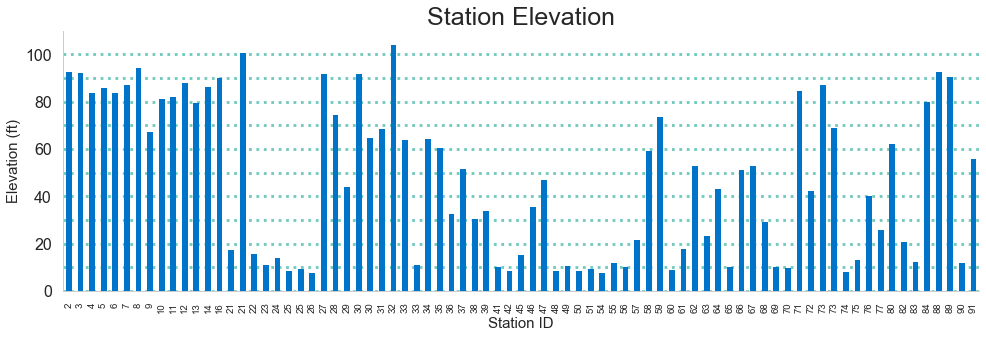

In [19]:
ax = stations_df.elevation_feet.plot(kind='bar', figsize=FIG_SIZE, color=COLOR_BLU)

ax.set_title('Station Elevation', size=TITLE_FONT_SIZE)
ax.set_xlabel('Station ID', size=LABEL_FONT_SIZE)
ax.set_ylabel('Elevation (ft)', size=LABEL_FONT_SIZE)

# remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xticks([x for x in range(0, stations_df.shape[0])])
ax.set_xticklabels([str(x) for x in [x for x in stations_df.station_id]], size=TICK_FONT_SIZE*0.8)
ax.minorticks_off()

ax.set_ylim([0, 110])
for y in range(0, 110, 10):
    ax.axhline(y, linestyle=':', color=COLOR_GRY, zorder=-1)

ax.grid(False)

plt.tight_layout()
plt.savefig('../01_charts/station_elevations.png')
plt.show()
plt.close()

# Set Float Precision to Six Significant Digits

In [20]:
precision = 6
stations_df = stations_df.round({'lat' : precision, 
                                 'long' : precision, 
                                 'elevation_meters' : precision, 
                                 'elevation_feet' : precision})

# Standardize Column Names
<p>This standardization is to bring column labels in line with those used across all data sets</p>

In [21]:
stations_df.rename(columns = {'landmark':'region', 'name':'station_name'}, inplace=True)
stations_df.head()

,station_id,station_name,lat,long,dock_count,region,first_service_date,last_service_date,zip_code,days_in_service,elevation_meters,elevation_feet
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-29,2016-08-31,95113,1098,28.275824,92.768450
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,2013-08-29,2016-08-31,95113,1098,28.038095,91.988502
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,2013-08-29,2016-08-31,95113,1098,25.517740,83.719620
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,2013-08-29,2016-08-31,95113,1098,26.192633,85.933834
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,2013-08-29,2016-08-31,95113,1098,25.543407,83.803830


***
# Preview EDA of Stations Data

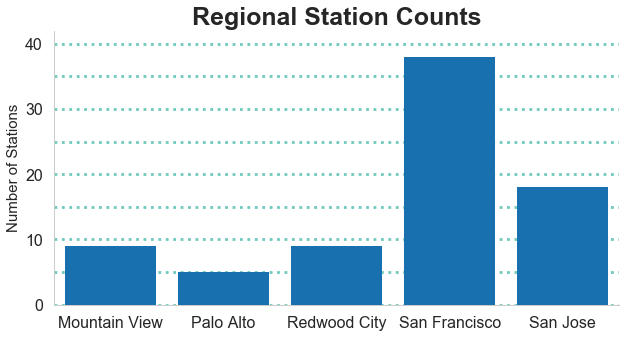

In [22]:
docks_by_region = stations_df.groupby('region')['dock_count'].count().to_frame()
plt.subplots(figsize=(10,6))
ax = sns.barplot(x=docks_by_region.index, y='dock_count', data=docks_by_region, color=COLOR_BLU)
ax.set_title('Regional Station Counts', size=TITLE_FONT_SIZE, weight='bold')

# remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('')
ax.set_ylabel('Number of Stations', size=LABEL_FONT_SIZE)

for y in range(0, 45, 5):
    ax.axhline(y, linestyle=':', color=COLOR_GRY, zorder=-1)

ax.grid(False)
plt.tight_layout()
plt.savefig('../01_charts/stations_by_region.png')
plt.show()
plt.close()

# Write Data to File - San Francisco Stations Only
<p>This analysis will focus on only stations within San Francisco, cleaned file will only consist of stations in zipcode 94107</p>

In [23]:
sf_stations = stations_df[stations_df.zip_code == '94107'].copy()
sf_stations.reset_index(inplace=True, drop=True)
sf_stations.to_pickle('../00_clean_data/bayareabikeshare/sf_station_data_cleaned.pkl')

In [24]:
sf_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 12 columns):
station_id            38 non-null int64
station_name          38 non-null object
lat                   38 non-null float64
long                  38 non-null float64
dock_count            38 non-null int64
region                38 non-null category
first_service_date    38 non-null datetime64[ns]
last_service_date     38 non-null datetime64[ns]
zip_code              38 non-null object
days_in_service       38 non-null int64
elevation_meters      38 non-null float64
elevation_feet        38 non-null float64
dtypes: category(1), datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 3.6+ KB


In [25]:
sf_stations.head(20)

,station_id,station_name,lat,long,dock_count,region,first_service_date,last_service_date,zip_code,days_in_service,elevation_meters,elevation_feet
0,39,Powell Street BART,37.783871,-122.408433,19,San Francisco,2013-08-29,2016-08-31,94107,1098,10.338920,33.920340
1,41,Clay at Battery,37.795001,-122.399970,15,San Francisco,2013-08-29,2016-08-31,94107,1098,3.082564,10.113399
2,42,Davis at Jackson,37.797280,-122.398436,15,San Francisco,2013-08-29,2016-08-31,94107,1098,2.519689,8.266697
3,45,Commercial at Montgomery,37.794231,-122.402923,15,San Francisco,2013-08-29,2016-08-31,94107,1098,4.575804,15.012480
4,46,Washington at Kearney,37.795425,-122.404767,15,San Francisco,2013-08-29,2016-08-31,94107,1098,10.850125,35.597524
5,47,Post at Kearney,37.788975,-122.403452,19,San Francisco,2013-08-29,2016-08-31,94107,1098,14.233555,46.698015
6,48,Embarcadero at Vallejo,37.799953,-122.398525,15,San Francisco,2013-08-29,2016-08-31,94107,1098,2.529956,8.300379
7,49,Spear at Folsom,37.789625,-122.390264,19,San Francisco,2013-08-29,2016-08-31,94107,1098,3.151700,10.340224
8,50,Harry Bridges Plaza (Ferry Building),37.795392,-122.394203,23,San Francisco,2013-08-29,2016-08-31,94107,1098,2.596962,8.520216
9,51,Embarcadero at Folsom,37.791464,-122.391034,19,San Francisco,2013-08-29,2016-08-31,94107,1098,2.797034,9.176620


In [26]:
stations_df.to_pickle('../00_clean_data/bayareabikeshare/station_data_cleaned.pkl')

# Quick Reference to 'Special Stations'
<p>Some stations were relocated, closed, or expanded during the program's recorded dataset being used in this analysis, this is a quick view to these notable stations</p>

In [27]:
# Stations that were relocated or expanded, thus there are duplicate 'station_id' values
special_stations = stations_df[stations_df.duplicated(subset=['station_id'], keep=False)]
special_stations.head(20)

,station_id,station_name,lat,long,dock_count,region,first_service_date,last_service_date,zip_code,days_in_service,elevation_meters,elevation_feet
14,21,Franklin at Maple,37.481758,-122.226904,15,Redwood City,2013-08-29,2015-09-14,94063,746,5.202400,17.068242
15,21,Sequoia Hospital,37.479303,-122.253755,15,Redwood City,2015-09-15,2016-06-30,94063,289,30.651674,100.563236
19,25,Stanford in Redwood City,37.485370,-122.203288,15,Redwood City,2013-08-29,2014-08-31,94063,367,2.523256,8.278398
20,25,Broadway at Main,37.486725,-122.225551,15,Redwood City,2014-09-01,2016-08-03,94063,702,2.866423,9.404274
25,30,Evelyn Park and Ride,37.390277,-122.066553,15,Mountain View,2013-08-29,2015-09-27,94041,759,27.981312,91.802204
26,30,Middlefield Light Rail Station,37.395337,-122.052476,15,Mountain View,2015-09-28,2016-08-31,94041,338,19.697617,64.624726
29,33,Rengstorff Avenue / California Street,37.400241,-122.099076,15,Mountain View,2013-08-29,2015-09-14,94041,746,19.398766,63.644244
30,33,Charleston Park/ North Bayshore Area,37.420909,-122.080623,15,Mountain View,2015-09-15,2016-08-31,94041,351,3.377911,11.082385
65,73,Grant Avenue at Columbus Avenue,37.798522,-122.407245,15,San Francisco,2013-08-29,2015-05-19,94107,628,26.583323,87.215625
66,73,Grant Avenue at Columbus Avenue,37.797900,-122.405942,19,San Francisco,2015-05-20,2016-08-31,94107,469,20.935102,68.684719


In [28]:
# Service was discontinued due to low ridership in Redwood City on September 1, 2016
redwood_city = stations_df[stations_df.region == 'Redwood City']
redwood_city.head(20)

,station_id,station_name,lat,long,dock_count,region,first_service_date,last_service_date,zip_code,days_in_service,elevation_meters,elevation_feet
14,21,Franklin at Maple,37.481758,-122.226904,15,Redwood City,2013-08-29,2015-09-14,94063,746,5.202400,17.068242
15,21,Sequoia Hospital,37.479303,-122.253755,15,Redwood City,2015-09-15,2016-06-30,94063,289,30.651674,100.563236
16,22,Redwood City Caltrain Station,37.486078,-122.232089,25,Redwood City,2013-08-29,2016-06-30,94063,1036,4.754227,15.597857
17,23,San Mateo County Center,37.488501,-122.231061,15,Redwood City,2013-08-29,2016-07-04,94063,1040,3.310725,10.861958
18,24,Redwood City Public Library,37.484219,-122.227424,15,Redwood City,2013-08-29,2016-07-04,94063,1040,4.212619,13.820928
19,25,Stanford in Redwood City,37.485370,-122.203288,15,Redwood City,2013-08-29,2014-08-31,94063,367,2.523256,8.278398
20,25,Broadway at Main,37.486725,-122.225551,15,Redwood City,2014-09-01,2016-08-03,94063,702,2.866423,9.404274
21,26,Redwood City Medical Center,37.487682,-122.223492,15,Redwood City,2013-08-29,2016-08-03,94063,1070,2.341812,7.683111
73,83,Mezes Park,37.491269,-122.236234,15,Redwood City,2014-02-20,2016-06-30,94063,861,3.690954,12.109428


# Quick Reference

In [29]:
stations_df[:45]

,station_id,station_name,lat,long,dock_count,region,first_service_date,last_service_date,zip_code,days_in_service,elevation_meters,elevation_feet
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-29,2016-08-31,95113,1098,28.275824,92.768450
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,2013-08-29,2016-08-31,95113,1098,28.038095,91.988502
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,2013-08-29,2016-08-31,95113,1098,25.517740,83.719620
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,2013-08-29,2016-08-31,95113,1098,26.192633,85.933834
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,2013-08-29,2016-08-31,95113,1098,25.543407,83.803830
5,7,Paseo de San Antonio,37.333798,-121.886943,15,San Jose,2013-08-29,2016-08-31,95113,1098,26.509548,86.973583
6,8,San Salvador at 1st,37.330165,-121.885831,15,San Jose,2013-08-29,2016-08-31,95113,1098,28.775412,94.407518
7,9,Japantown,37.348742,-121.894715,15,San Jose,2013-08-29,2016-08-31,95113,1098,20.444588,67.075419
8,10,San Jose City Hall,37.337391,-121.886995,15,San Jose,2013-08-29,2016-08-31,95113,1098,24.736252,81.155682
9,11,MLK Library,37.335885,-121.885660,19,San Jose,2013-08-29,2016-08-31,95113,1098,25.037251,82.143210


In [30]:
stations_df[45:]

,station_id,station_name,lat,long,dock_count,region,first_service_date,last_service_date,zip_code,days_in_service,elevation_meters,elevation_feet
45,51,Embarcadero at Folsom,37.791464,-122.391034,19,San Francisco,2013-08-29,2016-08-31,94107,1098,2.797034,9.176620
46,54,Embarcadero at Bryant,37.787152,-122.388013,15,San Francisco,2013-08-29,2016-08-31,94107,1098,2.324086,7.624953
47,55,Temporary Transbay Terminal (Howard at Beale),37.789756,-122.394643,23,San Francisco,2013-08-29,2016-08-31,94107,1098,3.633262,11.920151
48,56,Beale at Market,37.792251,-122.397086,19,San Francisco,2013-08-29,2016-08-31,94107,1098,3.057084,10.029802
49,57,5th at Howard,37.781752,-122.405127,15,San Francisco,2013-08-29,2016-08-31,94107,1098,6.598467,21.648515
50,58,San Francisco City Hall,37.778650,-122.418235,19,San Francisco,2013-08-29,2016-08-31,94107,1098,18.014444,59.102508
51,59,Golden Gate at Polk,37.781332,-122.418603,23,San Francisco,2013-08-29,2016-08-31,94107,1098,22.461260,73.691797
52,60,Embarcadero at Sansome,37.804770,-122.403234,15,San Francisco,2013-08-29,2016-08-31,94107,1098,2.659792,8.726352
53,61,2nd at Townsend,37.780526,-122.390288,27,San Francisco,2013-08-29,2016-08-31,94107,1098,5.421002,17.785441
54,62,2nd at Folsom,37.785299,-122.396236,19,San Francisco,2013-08-29,2016-08-31,94107,1098,16.062660,52.699016


In [31]:
stations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 12 columns):
station_id            79 non-null int64
station_name          79 non-null object
lat                   79 non-null float64
long                  79 non-null float64
dock_count            79 non-null int64
region                79 non-null category
first_service_date    79 non-null datetime64[ns]
last_service_date     79 non-null datetime64[ns]
zip_code              79 non-null object
days_in_service       79 non-null int64
elevation_meters      79 non-null float64
elevation_feet        79 non-null float64
dtypes: category(1), datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 7.1+ KB
